# Silicon burning

In [1]:
import pynucastro as pyna

## alpha-chain

First up--a small network that is just alpha nuclei

In [2]:
nuc = ["he4", "c12", "o16", "ne20",
       "mg24", "si28", "s32", "ar36", "ca40",
       "ti44", "cr48", "fe52", "ni56", "zn60"]

In [3]:
rl = pyna.ReacLibLibrary()

In [4]:
lib = rl.linking_nuclei(nuc)

In [5]:
rho = 1.e6
T = 3.e9

In [6]:
net = pyna.PythonNetwork(libraries=[lib])

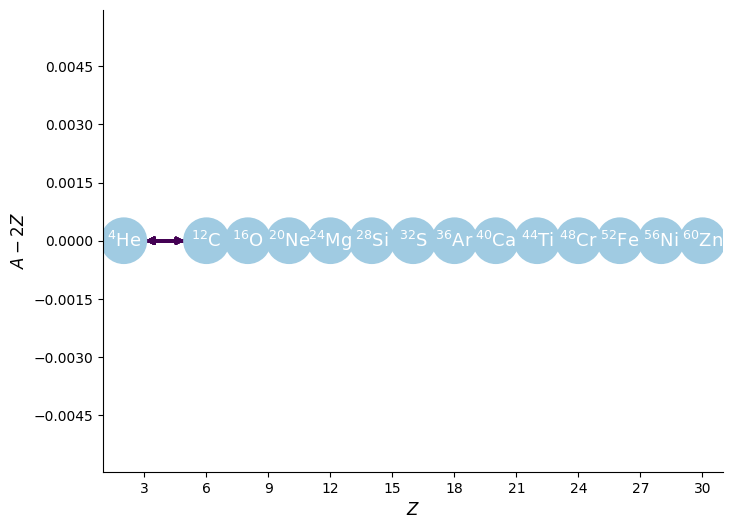

In [7]:
fig = net.plot(rotated=True)

In [8]:
net.write_network("siburn.py")

In [9]:
import siburn

In [10]:
from scipy.integrate import solve_ivp
import numpy as np

In [11]:
X0 = np.zeros(siburn.nnuc)
X0[siburn.jsi28] = 1.0

Y0 = X0 / siburn.A

In [12]:
tmax = 1.e10
sol = solve_ivp(siburn.rhs, [0, tmax], Y0, method="BDF", jac=siburn.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-10)

In [13]:
import matplotlib.pyplot as plt

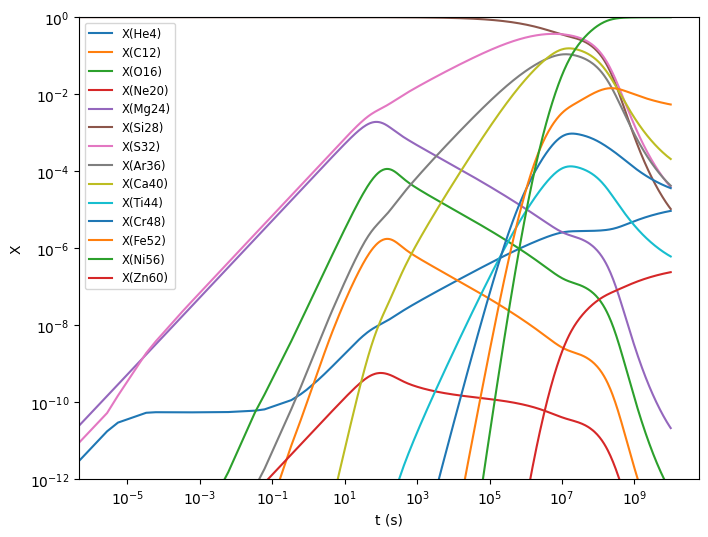

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(siburn.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * siburn.A[i], label=f"X({siburn.names[i].capitalize()})")

#ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-12, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

## Big Network

Now a much bigger network with weak rates

In [16]:
rl = pyna.ReacLibLibrary()
wl = pyna.TabularLibrary()

In [17]:
all_reactants = ["p",
                 "he4", "c12", "o16", "ne20", "mg24", "si28", "s32",
                 "ar36", "ca40", "ti44", "cr48", "fe52", "ni56",
                 "cu59", "zn60",
                 "al27", "p31", "cl35", "k39", "sc43", "v47", "mn51", "co55",
                 "n13", "n14", "f18", "ne21", "na22", "na23"]

core_lib = rl.linking_nuclei(all_reactants)

other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]

for r, mp in other_rates:
    _r = rl.get_rate_by_name(r)
    _r.modify_products(mp)
    core_lib.add_rate(_r)

for r in core_lib.get_rates():
    if sorted(r.products) in [[pyna.Nucleus("c12"), pyna.Nucleus("c12")],
                              [pyna.Nucleus("c12"), pyna.Nucleus("o16")],
                              [pyna.Nucleus("o16"), pyna.Nucleus("o16")]]:
        core_lib.remove_rate(r)

# C12+Ne20 and reverse
# (a,g) links between Na23 and Al27
# (a,g) links between Al27 and P31

rates_to_remove = ["p31(p,c12)ne20",
                   "si28(a,c12)ne20",
                   "ne20(c12,p)p31",
                   "ne20(c12,a)si28",
                   "na23(a,g)al27",
                   "al27(g,a)na23",
                   "al27(a,g)p31",
                   "p31(g,a)al27"]

for r in rates_to_remove:
    print("removing: ", r)
    _r = core_lib.get_rate_by_name(r)
    core_lib.remove_rate(_r)

iron_peak = ["n", "p", "he4",
             "mn51",
             "fe52", "fe53", "fe54", "fe55", "fe56",
             "co55", "co56", "co57",
             "ni56", "ni57", "ni58",
             "cu59", "zn60"]
iron_reaclib = rl.linking_nuclei(iron_peak)
iron_weak_lib = wl.linking_nuclei(iron_peak)
all_lib = core_lib + iron_reaclib + iron_weak_lib

rates_to_derive = []
for r in all_lib.get_rates():
    if r.reverse:
        # this rate was computed using detailed balance, regardless
        # of whether Q < 0 or not.  We want to remove it and then
        # recompute it
        rates_to_derive.append(r)

# now for each of those derived rates, look to see if the pair exists

for r in rates_to_derive:
    fr = all_lib.get_rate_by_nuclei(r.products, r.reactants)
    if fr:
        print(f"modifying {r} from {fr}")
        all_lib.remove_rate(r)
        d = pyna.DerivedRate(rate=fr, compute_Q=False, use_pf=True)
        all_lib.add_rate(d)

dupes = all_lib.find_duplicate_links()

rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, pyna.rates.ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    all_lib.remove_rate(r)

net = pyna.PythonNetwork(libraries=[all_lib])

net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47"])


removing:  p31(p,c12)ne20
removing:  si28(a,c12)ne20
removing:  ne20(c12,p)p31
removing:  ne20(c12,a)si28
removing:  na23(a,g)al27
removing:  al27(g,a)na23
removing:  al27(a,g)p31
removing:  p31(g,a)al27
modifying N13 ⟶ p + C12 from C12 + p ⟶ N13 + 𝛾
modifying O16 ⟶ He4 + C12 from C12 + He4 ⟶ O16 + 𝛾
modifying F18 ⟶ He4 + N14 from N14 + He4 ⟶ F18 + 𝛾
modifying Ne20 ⟶ He4 + O16 from O16 + He4 ⟶ Ne20 + 𝛾
modifying Na22 ⟶ p + Ne21 from Ne21 + p ⟶ Na22 + 𝛾
modifying Na22 ⟶ He4 + F18 from F18 + He4 ⟶ Na22 + 𝛾
modifying Mg24 ⟶ p + Na23 from Na23 + p ⟶ Mg24 + 𝛾
modifying Mg24 ⟶ He4 + Ne20 from Ne20 + He4 ⟶ Mg24 + 𝛾
modifying Si28 ⟶ p + Al27 from Al27 + p ⟶ Si28 + 𝛾
modifying Si28 ⟶ He4 + Mg24 from Mg24 + He4 ⟶ Si28 + 𝛾
modifying S32 ⟶ p + P31 from P31 + p ⟶ S32 + 𝛾
modifying S32 ⟶ He4 + Si28 from Si28 + He4 ⟶ S32 + 𝛾
modifying Cl35 ⟶ He4 + P31 from P31 + He4 ⟶ Cl35 + 𝛾
modifying Ar36 ⟶ p + Cl35 from Cl35 + p ⟶ Ar36 + 𝛾
modifying Ar36 ⟶ He4 + S32 from S32 + He4 ⟶ Ar36 + 𝛾
modifying K39 ⟶ He4 +

In [18]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Sans'
plt.rcParams['mathtext.it'] = 'Fira Sans:italic'
plt.rcParams['mathtext.bf'] = 'Fira Sans:bold'

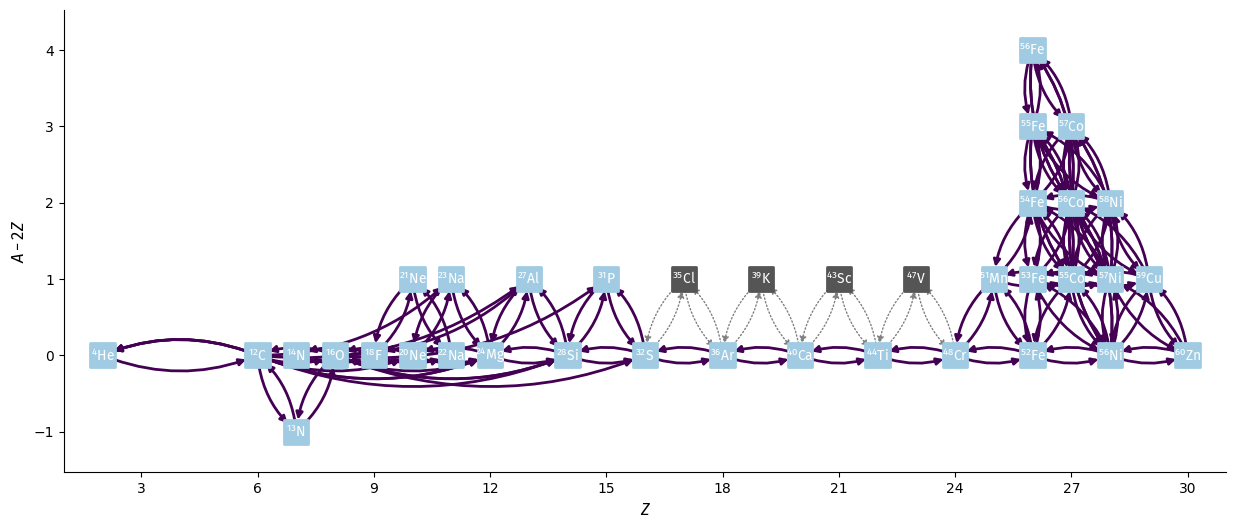

In [19]:
fig = net.plot(rotated=True, hide_xalpha=True, hide_xp=True, curved_edges=True,
               node_shape="s", node_size=300, node_font_size=10, size=(1500, 600))

In [20]:
net.write_network("siburn2.py")

/home/zingale/development/pynucastro/pynucastro/rates/rate.py:1779: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/home/zingale/development/pynucastro/pynucastro/rates/rate.py:1779: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/home/zingale/development/pynucastro/pynucastro/rates/rate.py:1779: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


In [21]:
import siburn2 as siburn

In [22]:
X0 = np.zeros(siburn.nnuc)
X0[siburn.jsi28] = 1.0

Y0 = X0 / siburn.A

In [65]:
tmax = 1.e10
sol = solve_ivp(siburn.rhs, [0, tmax], Y0, method="BDF", #jac=siburn.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-12)

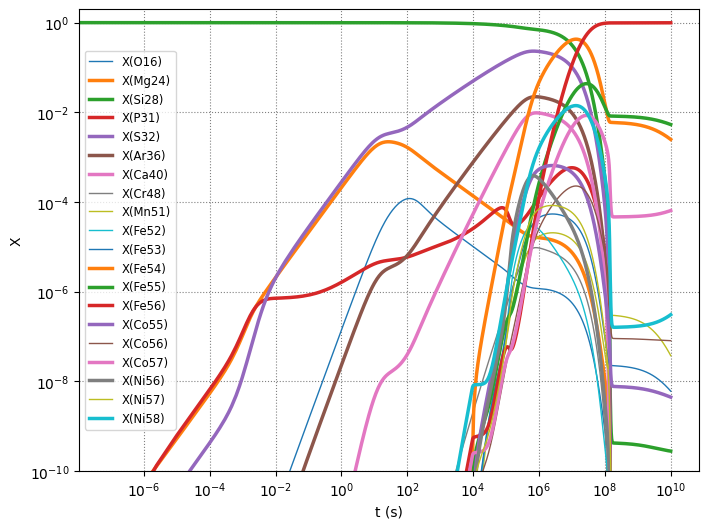

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(siburn.nnuc):
    lt = 1
    xmax = siburn.A[i] * sol.y[i, :].max()
    if xmax > 3.e-6:
        if xmax > 3.e-4:
            lt = 2.5
        ax.loglog(sol.t, sol.y[i,:] * siburn.A[i],
                  linewidth=lt,
                  label=f"X({siburn.names[i].capitalize()})")

#ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-10, 2.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")
ax.grid(color="0.5", ls=":")
fig.set_size_inches((8, 6))

In [67]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.658e-08 ...  9.996e+09  1.000e+10]
        y: [[ 0.000e+00  1.639e-24 ...  1.106e-11  1.106e-11]
            [ 0.000e+00  5.639e-13 ...  6.983e-11  6.984e-11]
            ...
            [ 0.000e+00  0.000e+00 ...  9.099e-18  9.102e-18]
            [ 0.000e+00  0.000e+00 ...  6.183e-25  6.186e-25]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f90f3452690>
 t_events: None
 y_events: None
     nfev: 47904
     njev: 3622
      nlu: 15890